# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between hexagonal tesselations created in 02_prepare_pois. This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Chris Larkin (c.larkin@ncl.ac.uk) or Michael Szell (michael.szell@gmail.com)   
Created: 2020-06-18  
Last modified: 2024-11-11

## Preliminaries

### Parameters

In [12]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [13]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: c5f55d63dae54067eb2a8c7f1eed65f6c678ceb3

numpy     : 1.26.4
igraph    : 0.11.6
haversine : 2.8.1
osmnx     : 1.9.4
geojson   : 3.1.0
shapely   : 2.0.6
osgeo     : 3.9.3
fiona     : 1.10.1
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
rasterio  : 1.3.11
geopandas : 0.14.4
tqdm      : 4.66.5
IPython   : 8.29.0
pyproj    : 3.7.0
watermark : 2.5.0
owslib    : 0.32.0
matplotlib: 3.8.4
csv       : 1.0
networkx  : 3.3
pandas    : 2.2.3
json      : 2.0.9



### Functions

In [14]:
%run -i functions.py

Loaded functions.



## Routing (shortest paths)

In [17]:
#### TEMPORARY PLOTTING ######

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import copy
import random
from tqdm import tqdm

def greedy_triangulation_routing(G, pois, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
    """Greedy Triangulation (GT) of a graph G's node subset pois,
    then routing to connect the GT (up to a quantile of betweenness
    betweenness_quantile).
    """

    if len(pois) < 2:
        return ([], [])  # We can't do anything with less than 2 POIs

    # Initialize GT structure
    pois_indices = set(G.vs.find(id=poi).index for poi in pois)
    G_temp = copy.deepcopy(G)
    for e in G_temp.es:  # Delete all edges
        G_temp.es.delete(e)
        
    poipairs = poipairs_by_distance(G, pois, weighting, True)
    if len(poipairs) == 0:
        return ([], [])

    print(poipairs)

    
    # Handle random pruning if specified
    if prune_measure == "random":
        GT = copy.deepcopy(G_temp.subgraph(pois_indices))
        for poipair, poipair_distance in poipairs:
            poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
        random.seed(0)
        edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
    else: 
        edgeorder = False
    
    GT_abstracts = []
    GTs = []
    
    for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
        GT_abstracts.append(GT_abstract)
        
        # Get node pairs we need to route, sorted by distance
        routenodepairs = {}
        for e in GT_abstract.es:
            routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
            print("start",e.source_vertex["id"], "end", e.target_vertex["id"],"weight", e["weight"])
            print("routenodepairs" , routenodepairs)
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])
        print("sorted", routenodepairs)

        # Routing and creating GT for each prune_quantile
        GT_indices = set()
        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
            GT_indices = GT_indices.union(sp)

        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)

        # Plot the current GT
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

        # Plotting the GTs after each loop
        fig, ax = plt.subplots(figsize=(10, 10))
        GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
        
        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
        plt.show()
    
    # Final plot with all GTs
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot all GTs with different colors
    for idx, GT in enumerate(GTs):
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")
        
        GT_gdf.plot(ax=ax, linewidth=1.5, label=f"GT {idx+1}")

    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("All Greedy Triangulations (GTs) After Processing")
    plt.show()

    return (GTs, GT_abstracts)


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Generating networks


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:448: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  e = pd.read_csv(p + prefix + '_edges.csv')
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:462: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  e['maxspeed'].fillna(20, inplace=True)  # Assign default speed of 20 where NaN


[[(12205522585, 10211941979), 552.5559999999999], [(747156761, 12205522585), 648.9139999999999], [(252203650, 11895667567), 660.4310000000002], [(12007379257, 7736056433), 713.827], [(6855654331, 4677291600), 730.3740000000003], [(248087665, 8145693692), 730.5090000000002], [(4680356273, 11879504433), 856.1739999999998], [(843549201, 747156761), 857.6809999999999], [(282479893, 248087665), 861.909], [(4566633619, 4677291600), 874.127], [(2509569839, 1354004415), 882.3659999999998], [(1797118756, 1797144940), 903.342], [(11204688, 7997941723), 918.107], [(1797144940, 8478092537), 924.971], [(1471905674, 8758718511), 973.929], [(162517554, 10211941979), 985.5830000000003], [(3360272528, 4680356273), 1000.7159999999999], [(939261595, 11725802573), 1118.6470000000002], [(747156761, 10211941979), 1148.334], [(321752074, 776471329), 1175.7009999999998], [(7946245423, 1354004415), 1177.4950000000008], [(4566633619, 3836516757), 1186.9739999999993], [(3364362745, 7736056433), 1191.834], [(1625

start 33518545 end 4566633619 weight 1294.9380000000006
routenodepairs {(33518545, 4566633619): 1294.9380000000006}
start 1471905674 end 11895667567 weight 2046.4630000000002
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002}
start 4566633619 end 11895667567 weight 2629.4959999999987
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002, (4566633619, 11895667567): 2629.4959999999987}
sorted [((33518545, 4566633619), 1294.9380000000006), ((1471905674, 11895667567), 2046.4630000000002), ((4566633619, 11895667567), 2629.4959999999987)]


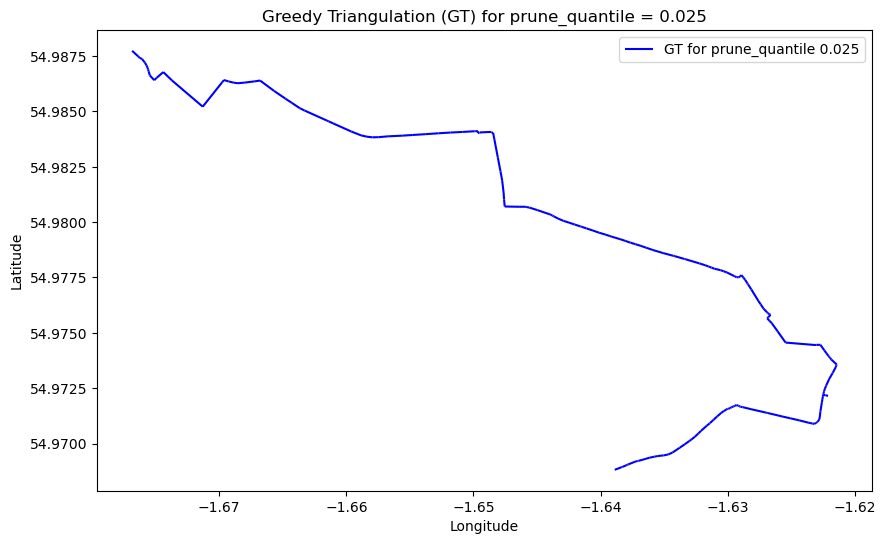

start 33518545 end 4566633619 weight 1294.9380000000006
routenodepairs {(33518545, 4566633619): 1294.9380000000006}
start 1471905674 end 11895667567 weight 2046.4630000000002
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002}
start 7946245423 end 4566633619 weight 2080.6299999999997
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002, (7946245423, 4566633619): 2080.6299999999997}
start 4566633619 end 11895667567 weight 2629.4959999999987
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002, (7946245423, 4566633619): 2080.6299999999997, (4566633619, 11895667567): 2629.4959999999987}
start 1557944834 end 12205522585 weight 2814.512999999998
routenodepairs {(33518545, 4566633619): 1294.9380000000006, (1471905674, 11895667567): 2046.4630000000002, (7946245423, 4566633619): 2080.6299999999997, (4566633619, 11895667567): 2629.49599

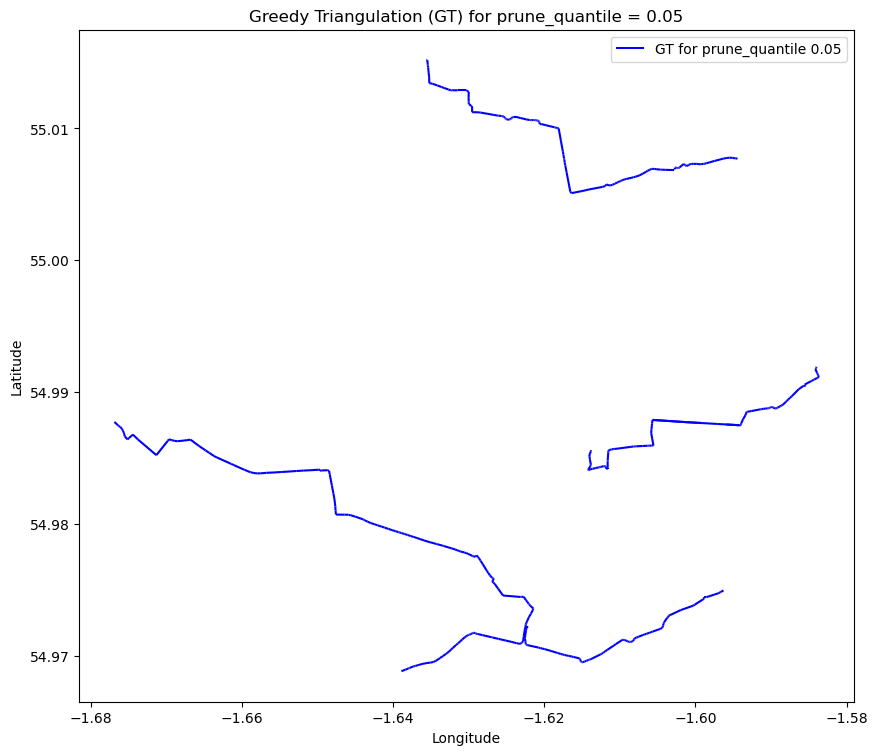

start 3836516757 end 4566633619 weight 1186.9739999999993
routenodepairs {(3836516757, 4566633619): 1186.9739999999993}
start 33518545 end 4566633619 weight 1294.9380000000006
routenodepairs {(3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006}
start 33518545 end 8478092537 weight 1504.9989999999998
routenodepairs {(3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, (33518545, 8478092537): 1504.9989999999998}
start 1471905674 end 11895667567 weight 2046.4630000000002
routenodepairs {(3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, (33518545, 8478092537): 1504.9989999999998, (1471905674, 11895667567): 2046.4630000000002}
start 7946245423 end 4566633619 weight 2080.6299999999997
routenodepairs {(3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, (33518545, 8478092537): 1504.9989999999998, (1471905674, 11895667567): 2046.4630000000002, (

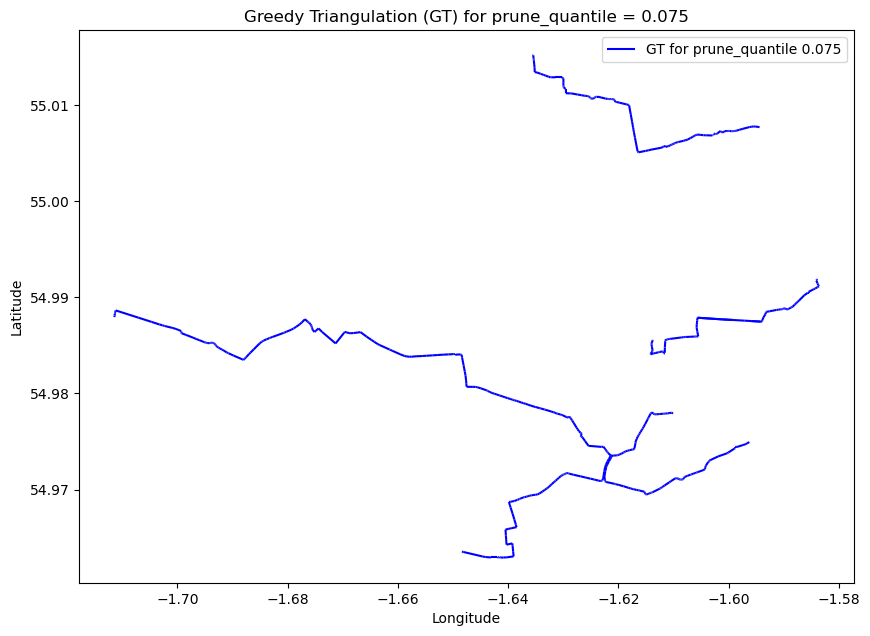

start 162517554 end 10211941979 weight 985.5830000000003
routenodepairs {(162517554, 10211941979): 985.5830000000003}
start 3836516757 end 4566633619 weight 1186.9739999999993
routenodepairs {(162517554, 10211941979): 985.5830000000003, (3836516757, 4566633619): 1186.9739999999993}
start 33518545 end 4566633619 weight 1294.9380000000006
routenodepairs {(162517554, 10211941979): 985.5830000000003, (3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006}
start 33518545 end 8478092537 weight 1504.9989999999998
routenodepairs {(162517554, 10211941979): 985.5830000000003, (3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, (33518545, 8478092537): 1504.9989999999998}
start 1557944834 end 4566633619 weight 2031.9570000000003
routenodepairs {(162517554, 10211941979): 985.5830000000003, (3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, (33518545, 8478092537): 1504.9989999999998, (15579

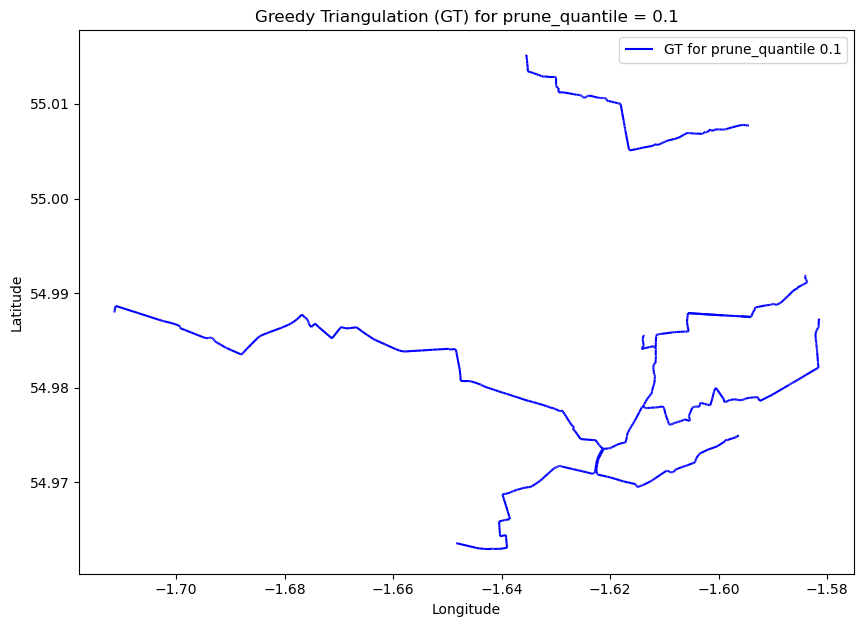

start 162517554 end 10211941979 weight 985.5830000000003
routenodepairs {(162517554, 10211941979): 985.5830000000003}
start 7946245423 end 1354004415 weight 1177.4950000000008
routenodepairs {(162517554, 10211941979): 985.5830000000003, (7946245423, 1354004415): 1177.4950000000008}
start 3836516757 end 4566633619 weight 1186.9739999999993
routenodepairs {(162517554, 10211941979): 985.5830000000003, (7946245423, 1354004415): 1177.4950000000008, (3836516757, 4566633619): 1186.9739999999993}
start 33518545 end 4566633619 weight 1294.9380000000006
routenodepairs {(162517554, 10211941979): 985.5830000000003, (7946245423, 1354004415): 1177.4950000000008, (3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006}
start 33518545 end 8478092537 weight 1504.9989999999998
routenodepairs {(162517554, 10211941979): 985.5830000000003, (7946245423, 1354004415): 1177.4950000000008, (3836516757, 4566633619): 1186.9739999999993, (33518545, 4566633619): 1294.9380000000006, 

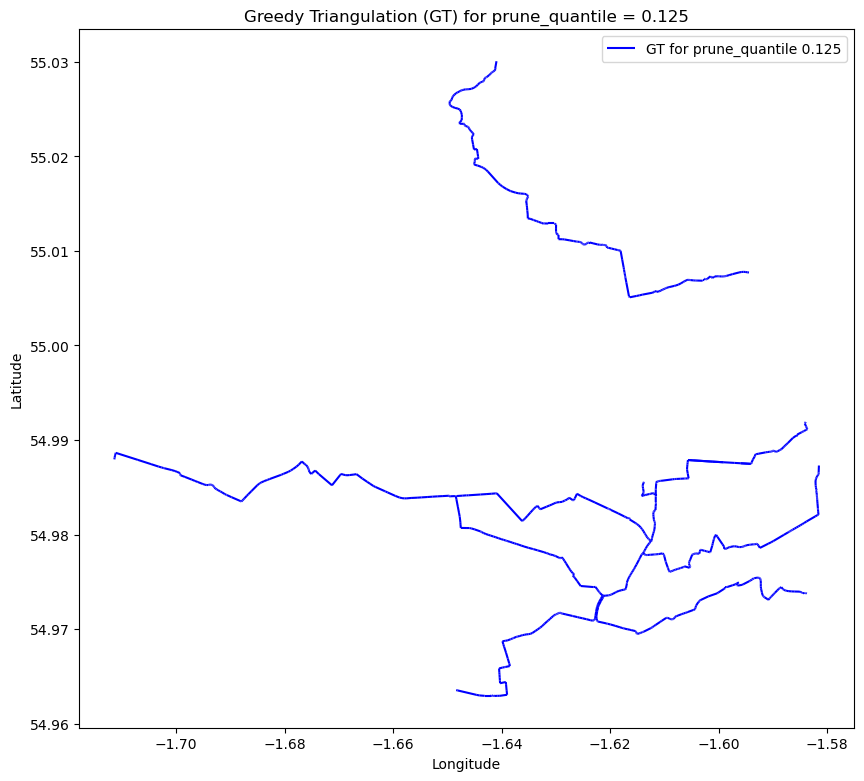

Cities:   0%|          | 0/1 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [18]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Generating networks")

    # Load networks
    #G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall', weighting=weighting)
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting) # to load car and cycle network
        
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidsbikeall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    
    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing(G_carall, nnids, weighting, prune_quantiles, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)
    
    # Restore orignal edge lengths
    if weighting == True:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)


    # Write results
    results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": prune_quantiles, "GTs": GTs, "GT_abstracts": GT_abstracts, "MST": MST, "MST_abstract": MST_abstract}
    write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [16]:
Audio(sound_file, autoplay=True)